In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv
from pathlib import Path

In [2]:
fire_data_merged = Path("../outputs/geojson/ca_fire_all.csv")
fire_data_merged_df = pd.read_csv(fire_data_merged, encoding="ISO-8859-1")
fire_data_merged_df.head()

,Unnamed: 0,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES
0,0,2013-08-03,2013-08-04,Miscellaneous,10.934740
1,1,2013-08-09,2013-08-09,Miscellaneous,206.080700
2,2,2013-06-09,2013-06-09,Equipment Use,17.784730
3,3,2013-09-07,2013-09-09,Miscellaneous,5.024302
4,4,2013-05-13,2013-05-14,Vehicle,49.124420


In [3]:
fire_data_merged_df.loc[fire_data_merged_df['ALARM_DATE'] == '0219-05-29', 'ALARM_DATE'] = '2019-05-09'
fire_data_merged_df.loc[fire_data_merged_df['CONT_DATE'] == '0219-05-29', 'CONT_DATE'] = '2019-05-09'
fire_data_merged_df.loc[fire_data_merged_df['CONT_DATE'] == '2022-09-07', 'CONT_DATE'] = '2021-09-07'
fire_data_merged_df.loc[fire_data_merged_df['CONT_DATE'] == '2022-05-06', 'CONT_DATE'] = '2021-05-06'

In [4]:
fire_data_merged_df['CONT_DATE'] = pd.to_datetime(fire_data_merged_df['CONT_DATE'])
fire_data_merged_df['ALARM_DATE'] = pd.to_datetime(fire_data_merged_df['ALARM_DATE'])
fire_data_merged_df['Duration'] = fire_data_merged_df['CONT_DATE'] - fire_data_merged_df['ALARM_DATE']

In [5]:
# Replace 'vehicle' and 'railroad' with 'transportation' in 'causes' column
fire_data_merged_df['CAUSE'].replace(['Vehicle', 'Railroad', 'Aircraft'], 'Transportation', inplace=True)
fire_data_merged_df.sort_values(by='GIS_ACRES')

C:\Users\Long\AppData\Local\Temp\ipykernel_22928\3302345474.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_data_merged_df['CAUSE'].replace(['Vehicle', 'Railroad', 'Aircraft'], 'Transportation', inplace=True)


,Unnamed: 0,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Duration
751,154,2017-12-22,2017-12-22,Unknown/Unidentified,1.356887e-03,0 days
570,273,2015-09-28,2015-09-28,Unknown/Unidentified,2.611810e-03,0 days
1159,562,2017-09-12,2017-09-12,Lightning,2.815646e-03,0 days
747,150,2017-11-10,2017-11-10,Unknown/Unidentified,2.960623e-03,0 days
724,127,2017-01-30,2017-01-30,Unknown/Unidentified,3.896726e-03,0 days
...,...,...,...,...,...,...
1751,236,2020-08-17,2020-12-03,Lightning,3.187973e+05,108 days
1756,241,2020-09-04,2020-12-24,Unknown/Unidentified,3.798424e+05,111 days
1689,174,2020-08-16,2020-09-11,Lightning,3.968245e+05,26 days
2376,367,2021-07-14,2021-10-25,Powerline,9.634054e+05,103 days


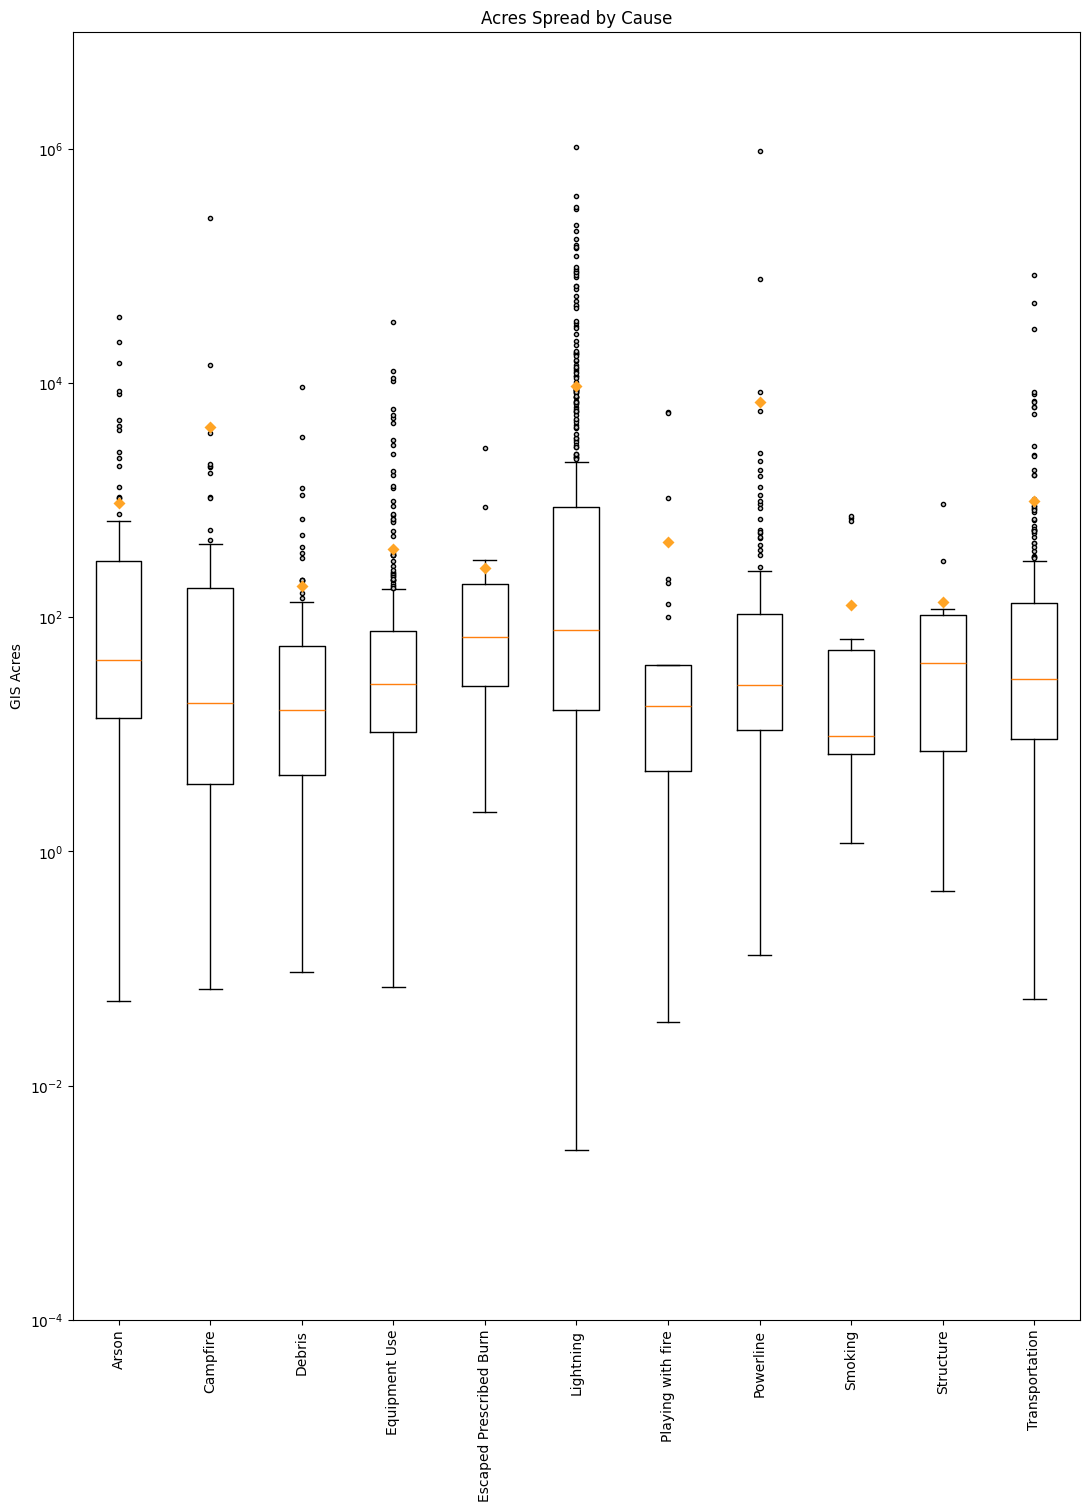

In [31]:
cause_list = fire_data_merged_df['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_data_merged_df[fire_data_merged_df['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=3), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.0001, 10000000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres')
plt.yscale('log')
plt.title('Acres Spread by Cause')
plt.tight_layout()
plt.savefig("outputs/acres_boxplot_all.png")
plt.show()

In [7]:
cause_gis

,Unnamed: 0,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Duration
2,2,2013-06-09,2013-06-09,Equipment Use,17.784730,0 days
4,4,2013-05-13,2013-05-14,Transportation,49.124420,1 days
5,5,2013-07-09,2013-07-09,Equipment Use,11.978900,0 days
6,6,2013-11-12,2013-11-19,Arson,14.521830,7 days
7,7,2013-05-03,2013-05-04,Campfire,4.500647,1 days
...,...,...,...,...,...,...
2976,274,2023-08-16,2023-09-28,Lightning,7850.580000,43 days
2977,275,2023-08-15,2023-10-03,Lightning,1997.206000,49 days
2982,280,2023-08-15,2023-09-15,Lightning,1684.730000,31 days
2983,281,2023-08-15,2023-10-25,Lightning,34188.450000,71 days


In [8]:
fire_data_merged_df['Duration_days'] = fire_data_merged_df['Duration'].dt.days
fire_data_merged_df.sort_values(by='Duration')

,Unnamed: 0,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Duration,Duration_days
2654,258,2022-08-31,2021-09-07,Unknown/Unidentified,5227.923000,-358 days,-358
422,125,2015-12-03,2015-03-13,Unknown/Unidentified,22.354660,-265 days,-265
437,140,2015-11-08,2015-08-13,Unknown/Unidentified,9.354076,-87 days,-87
1019,422,2017-09-27,2017-08-29,Arson,113.054400,-29 days,-29
2770,68,2023-08-28,2023-08-28,Unknown/Unidentified,33.320770,0 days,0
...,...,...,...,...,...,...,...
2283,274,2021-06-28,2022-01-03,Unknown/Unidentified,10591.030000,189 days,189
1478,275,2019-05-23,2019-12-02,Miscellaneous,732.400300,193 days,193
463,166,2015-06-17,2015-12-31,Miscellaneous,31284.440000,197 days,197
8,8,2013-05-30,2013-12-18,Miscellaneous,30267.690000,202 days,202


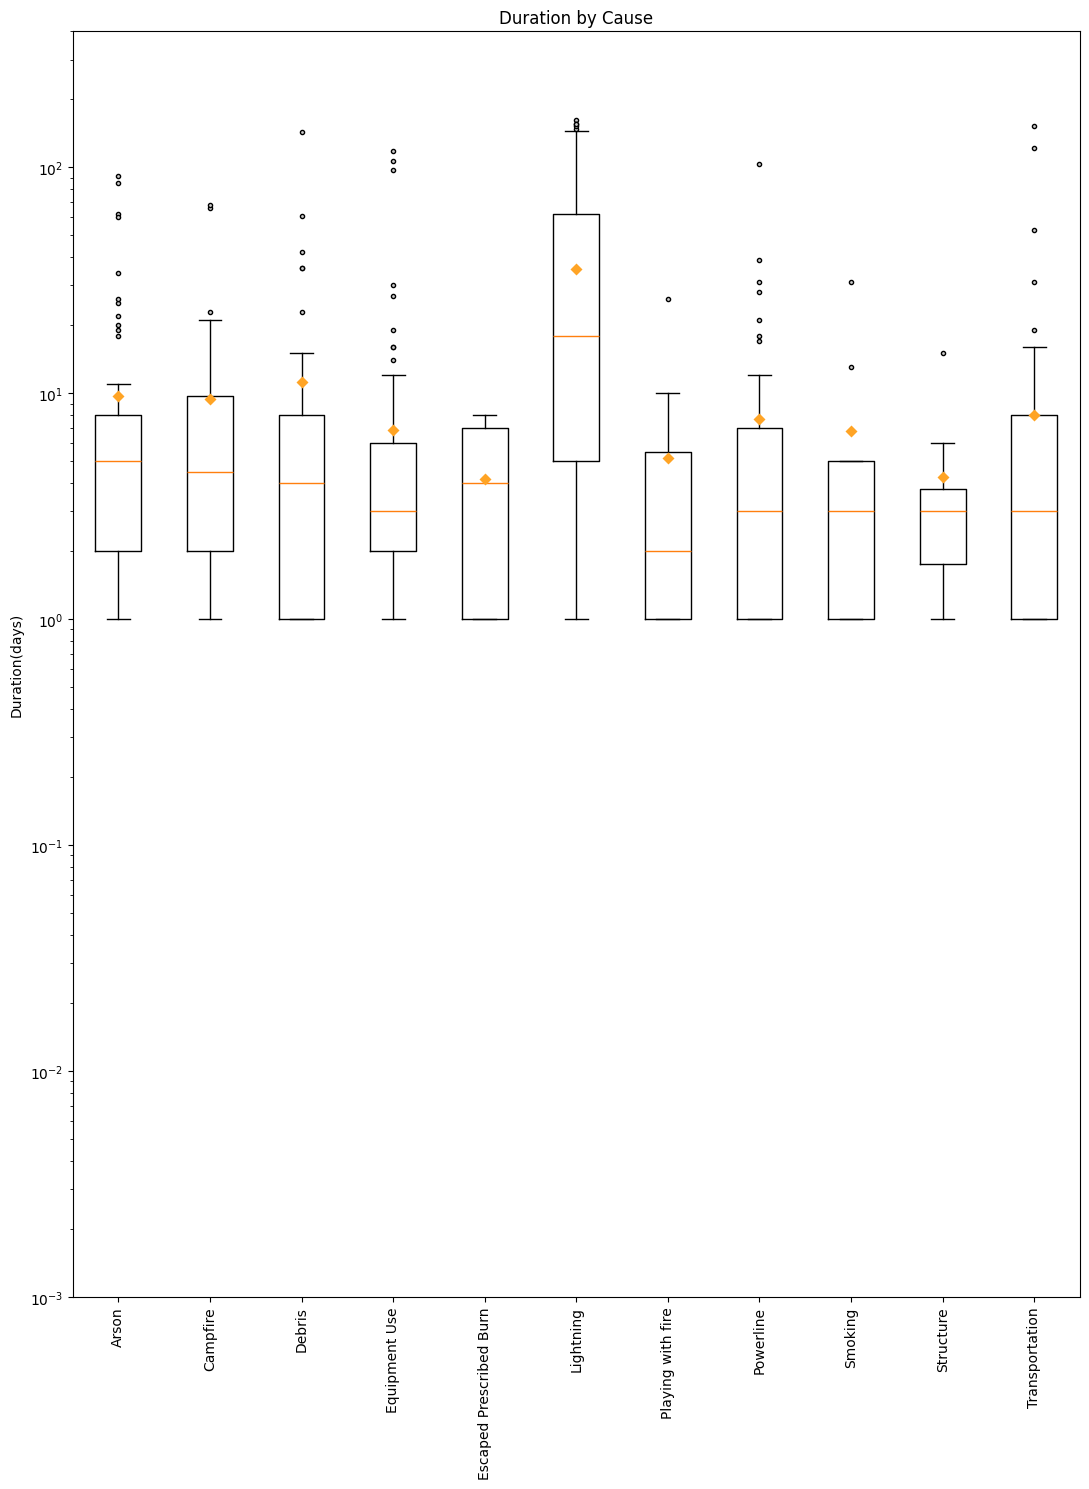

In [30]:
df_filtered = fire_data_merged_df[fire_data_merged_df['Duration_days'] > 0]
cause_list = df_filtered['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = df_filtered[df_filtered['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['Duration_days'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=3), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.001, 400)
plt.xticks(rotation=90)
plt.ylabel('Duration(days)')
plt.yscale('log')
plt.title('Duration by Cause')
plt.tight_layout()
plt.savefig("outputs/Duration_boxplot_all.png")
plt.show()

In [10]:
fire_data_23 = Path("outputs/fire_source_2023.csv")
fire_data_22 = Path("outputs/fire_source_2022.csv")
fire_data_21 = Path("outputs/fire_source_2021.csv")
fire_data_20 = Path("outputs/fire_source_2020.csv")
fire_data_19 = Path("outputs/fire_source_2019.csv")
fire_data_17 = Path("outputs/fire_source_2017.csv")
fire_data_15 = Path("outputs/fire_source_2015.csv")
fire_data_13 = Path("outputs/fire_source_2013.csv")

In [11]:
fire_2023_df = pd.read_csv(fire_data_23, encoding="ISO-8859-1")
fire_2022_df = pd.read_csv(fire_data_22, encoding="ISO-8859-1")
fire_2021_df = pd.read_csv(fire_data_21, encoding="ISO-8859-1")
fire_2020_df = pd.read_csv(fire_data_20, encoding="ISO-8859-1")
fire_2019_df = pd.read_csv(fire_data_19, encoding="ISO-8859-1")
fire_2017_df = pd.read_csv(fire_data_17, encoding="ISO-8859-1")
fire_2015_df = pd.read_csv(fire_data_15, encoding="ISO-8859-1")
fire_2013_df = pd.read_csv(fire_data_13, encoding="ISO-8859-1")
fire_2013_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Lightning,26.00,997.18,56
1,Equipment Use,1.53,138.83,34
2,Smoking,1.00,232.97,6
3,Campfire,14.80,17662.81,15
4,Debris,1.50,133.87,8
5,Railroad,0.00,17.30,2
6,Arson,12.33,5197.43,9
7,Playing with fire,0.00,41.23,4
8,Vehicle,0.92,100.82,12
9,Powerline,1.79,66.13,14


In [12]:
merged_df = pd.concat([fire_2013_df, fire_2015_df], ignore_index=True)
summed_df = merged_df.groupby('Causes').sum().reset_index()

In [13]:
summed_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Arson,18.83,5690.82,17
1,Campfire,17.42,19598.25,23
2,Debris,24.35,197.23,21
3,Equipment Use,3.39,625.83,62
4,Escaped Prescribed Burn,7.00,1012.83,6
5,Lightning,58.89,4870.98,165
6,Playing with fire,9.00,2011.99,7
7,Powerline,3.91,455.19,22
8,Railroad,0.00,17.30,2
9,Smoking,1.00,240.44,7


In [14]:
merged_df = pd.concat([summed_df, fire_2017_df], ignore_index=True)
merged_df = pd.concat([merged_df, fire_2019_df], ignore_index=True)
merged_df = pd.concat([merged_df, fire_2020_df], ignore_index=True)
merged_df = pd.concat([merged_df, fire_2021_df], ignore_index=True)
merged_df = pd.concat([merged_df, fire_2022_df], ignore_index=True)
merged_df = pd.concat([merged_df, fire_2023_df], ignore_index=True)
summed_df = merged_df.groupby('Causes').sum().reset_index()

In [15]:
summed_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Aircraft,0.00,3.08,2
1,Arson,44.64,8974.91,137
2,Campfire,37.33,20492.40,68
3,Debris,38.68,1560.30,112
4,Equipment Use,26.66,2589.41,328
5,Escaped Prescribed Burn,14.04,1531.81,21
6,Lightning,250.27,71938.48,534
7,Playing with fire,12.37,2556.56,30
8,Powerline,25.09,65635.14,155
9,Railroad,4.00,261.42,5


In [16]:
summed_df.rename(columns={'Number of Occurences (in the Year)': 'Number of Occurences (Overall)'}, inplace=True)
summed_df['Average Duration (days)'] = summed_df['Average Duration (days)']/8
summed_df['Average GIS Acres'] = summed_df['Average GIS Acres']/8
summed_df['Number of Occurences (Overall)'] = summed_df['Number of Occurences (Overall)']/8
summed_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (Overall)
0,Aircraft,0.00000,0.38500,0.250
1,Arson,5.58000,1121.86375,17.125
2,Campfire,4.66625,2561.55000,8.500
3,Debris,4.83500,195.03750,14.000
4,Equipment Use,3.33250,323.67625,41.000
5,Escaped Prescribed Burn,1.75500,191.47625,2.625
6,Lightning,31.28375,8992.31000,66.750
7,Playing with fire,1.54625,319.57000,3.750
8,Powerline,3.13625,8204.39250,19.375
9,Railroad,0.50000,32.67750,0.625


In [17]:
summed_df.to_csv("outputs/fire_source_merged.csv",
                  encoding="utf-8", index=False, header=True)

In [18]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in summed_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (Overall)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (Overall)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (Overall)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (Overall)
0,Man-Made,32.11375,13862.60375,141.75
1,Natural,31.28375,8992.31000,66.75


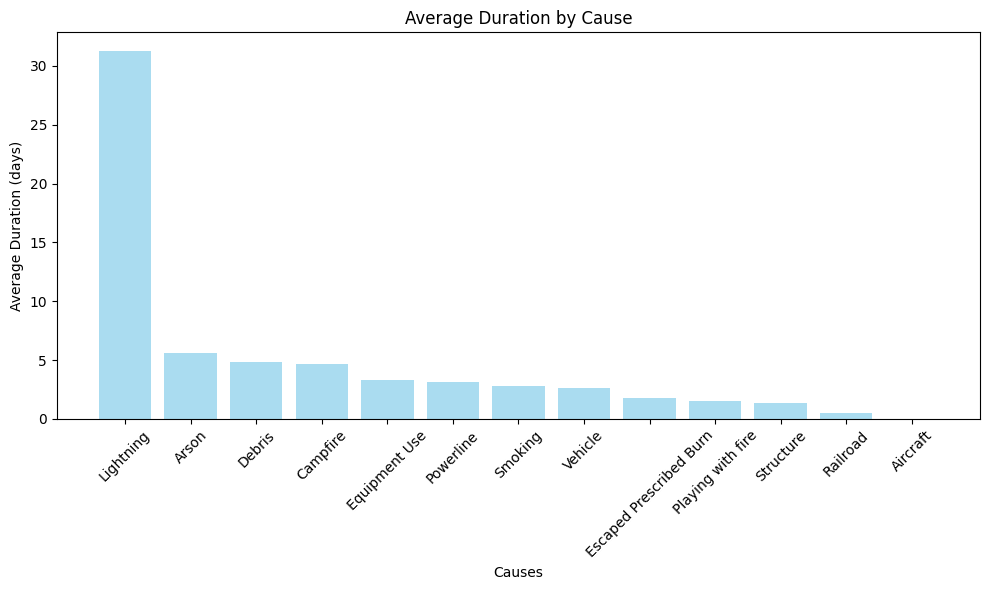

In [29]:
summed_df = summed_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(summed_df['Causes'], summed_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("outputs/Duration_bar_all.png")
plt.show()

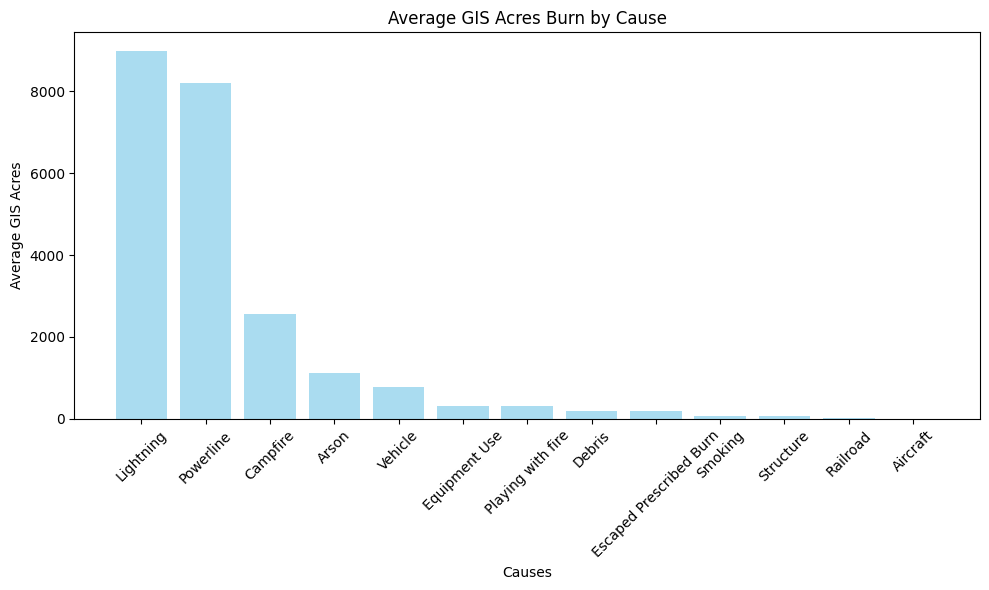

In [20]:
summed_df = summed_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(summed_df['Causes'], summed_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

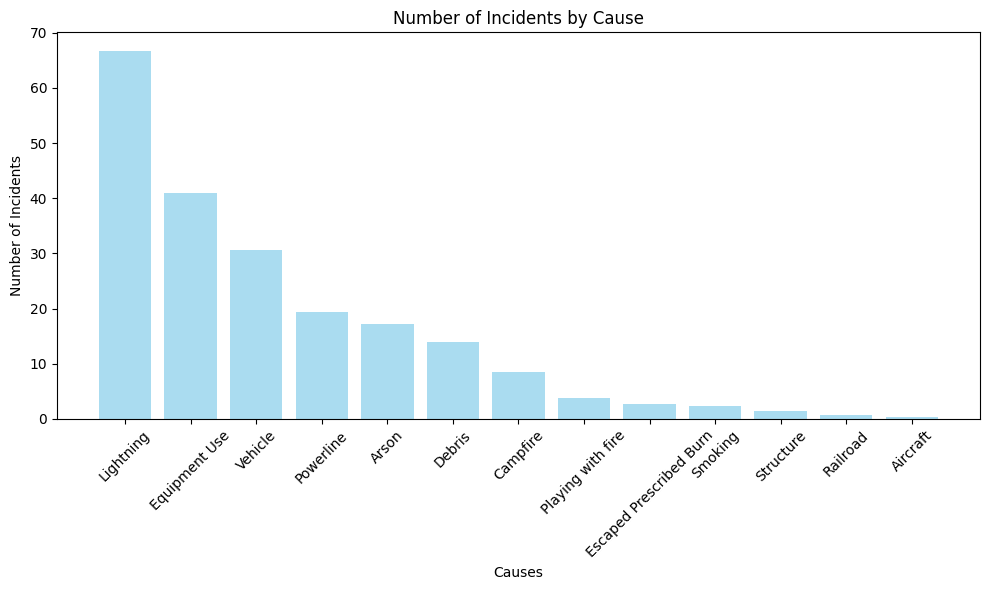

In [21]:
summed_df = summed_df.sort_values(by='Number of Occurences (Overall)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(summed_df['Causes'], summed_df['Number of Occurences (Overall)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

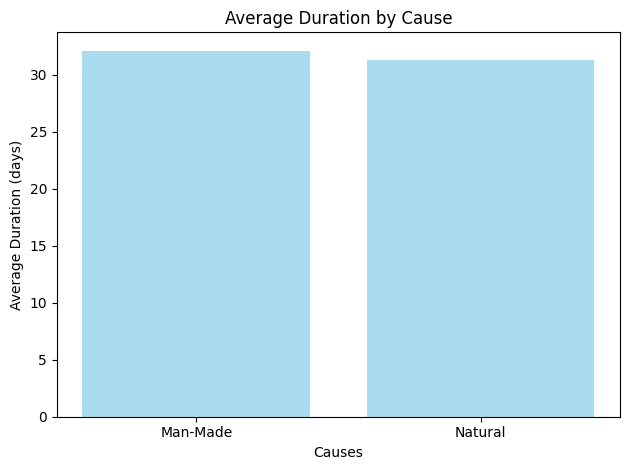

In [22]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

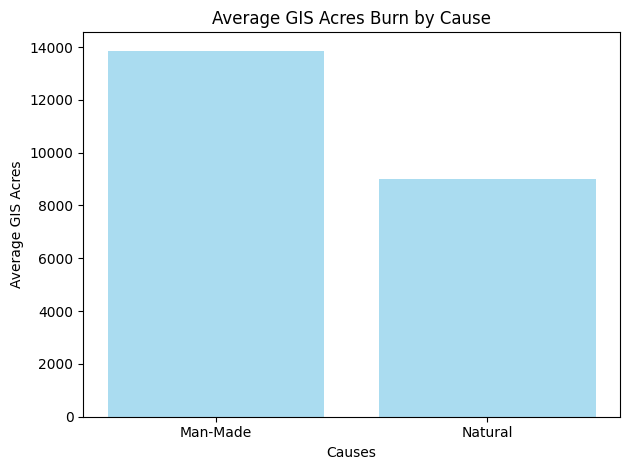

In [23]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

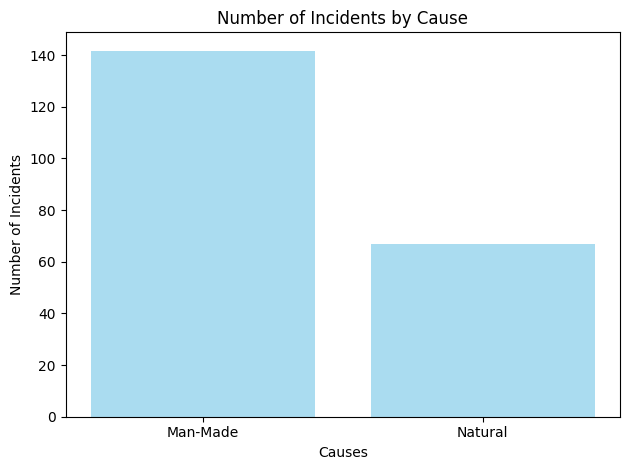

In [28]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (Overall)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.savefig("outputs/manVSnat_incidents_all.png")
plt.show()